# Results Prototype Notebook

## Framing

This notebook generates the linear probing and inter-class distance metrics for a trained Perceiver Autoencoder model (with or without predictive loss). 

## Design
 - Load the `validate` set from Kinetics 400. 
     - Parse the text file in `Multimodal_Foundation/datasets/Kinetics/frame_cnts_val.txt` to get the actual number of frames. 
     - Load some random segment from that number of frames (use random seed or store this somehow). 
     - Figure out how to make a `tf.Dataset` with labels from this. 
 - Load a trained model, parse the data, generate latent representations of each video in the validation set. 
 - Do a cheeky PCA on the data, take a look. 
 - Figure out how the ViT-MAE paper performed linear probing. 
 - Perform linear probing, compute top-5 accuracy. 

In [1]:
## Import box
import os 
import sys 
import random
import pathlib
import itertools
import collections
import math
import argparse
import datetime
import pickle
import pdb
import time
import re
from packaging import version

os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

sys.path.append("../src")       # Adding src folder to path
sys.path.append("../src/utils") # Adding utils folder to path

import tensorflow as tf 
from tensorflow import keras
# import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import imageio
from tqdm import tqdm 

import model
import video_loader as vl
import video_preprocess as vp
import train_m2
import parallel_video_loader as pvl

2022-12-21 10:51:33.404393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 10:51:33.540252: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-12-21 10:51:33.568401: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-21 10:51:34.159811: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

LOGICAL GPUs:  [LogicalDevice(name='/device:GPU:0', device_type='GPU'), LogicalDevice(name='/device:GPU:1', device_type='GPU')]


2022-12-21 10:51:35.110806: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-21 10:51:37.264688: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-12-21 10:51:37.264745: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21840 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:1a:00.0, compute capability: 8.6
2022-12-21 10:51:37.266249: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWT

In [2]:
## Constants -- specify which experiment we are going to generate 
#               embeddings for and test.
EXPERIMENT_FOLDER = "../training/debug/2022-12-20_15:31:39"
assert os.path.exists(EXPERIMENT_FOLDER)

## 0: Load Experiment Params

To make sure we format the data properly, we need to know the contents of `data_format_args.pkl` from the relevant experiment. Let's load this dict here:

In [3]:
# Load `data_format_args.pkl` !
instant_param_pth = os.path.join(EXPERIMENT_FOLDER, 'instantiation_params.pkl')
with open(instant_param_pth, 'rb') as handle:
    instantiation_params = pickle.load(handle)


# Load `data_format_args.pkl` !
data_format_pth = os.path.join(EXPERIMENT_FOLDER, 'data_format_args.pkl')
with open(data_format_pth, 'rb') as handle:
    data_format_args = pickle.load(handle)

predictive_param_pth = os.path.join(EXPERIMENT_FOLDER, 'predictive_training_kwargs.pkl')
with open(predictive_param_pth, 'rb') as handle:
    predictive_training_kwargs = pickle.load(handle)

print(data_format_args, "\n")           # dataset formatting args
print(instantiation_params, "\n")       # model instantiation args
print(predictive_training_kwargs, "\n") # Predictive coding args (incl. `num_frames`)

{'k_space': 15, 'mu_space': 20, 'k_time': 64, 'mu_time': 200, 'out_size': ['120', '180'], 'patch_height': 8, 'patch_width': 8, 'patch_duration': 1} 

{'encoder_args': [1], 'encoder_kwargs': {'tfblock_residual': False, 'n_heads': 15, 'key_dim': 15, 'mha_dropout': 0.1}, 'latent_ev_args': [1], 'latent_ev_kwargs': {'distinct_blocks': True, 'tfblock_residual': False, 'n_heads': 15, 'key_dim': 15, 'mha_dropout': 0.1}, 'decoder_args': [192, 1, 0], 'decoder_kwargs': {'tfblock_residual': False, 'n_heads': 15, 'key_dim': 15, 'mha_dropout': 0.1}, 'perceiver_kwargs': {'code_dim': 191, 'latent_dims': [50, 100]}} 

{'alpha': 0.7, 'present_time_window': 1, 'prediction_time_window': 3, 'prob_prediction_select': 0.1, 'mask_ratio': 0.3, 'num_frames': 50} 



## 1: Loading the Data (Kinetics-400 Validation Set)

The relative path to the Kinetics 400 validation set is `../datasets/Kinetics/validate`. Within this folder, each of the 400 action classes has a subfolder containing videos of that class. 

There is also a text file called `frame_cnts_val.txt`. Each line pertains to one video file and is of the form `Easy: 411.0, hard: 301 -- validate/testifying/_yMeY9-Gi0k.mp4`. "Easy" refers to the number of frames as counted by the OpenCV default frame counting system, whereas "hard" refers to the number of frames as counted when actually reading in the videos. After that is the path of the video. The "hard" count for the number of frames should be used when sampling frames from the video as the "easy" count generally overestimates. 

In [4]:
frame_count_file_path = "../datasets/Kinetics/validate/frame_cnts_val.txt"
dataset_path = "../datasets/Kinetics"

### 1a: Load `frame_cnts_val.txt`

This should be loaded as a list of tuples of `(path, frame_count)`. 

In [5]:
def get_frame_counts(path_to_counts, dataset_path): 
    frame_count_list = []
    with open(path_to_counts) as count_file:
        for line in count_file:
            hard_cnt = re.search(r'hard: \d+', line)
            if hard_cnt is None:
                continue
            hard_cnt = int(hard_cnt.group(0)[6:])

            path = re.search(r'-- \S*', line)
            path = path.group(0)[3:]

            new_tup = (os.path.join(dataset_path, path), hard_cnt)
            frame_count_list.append(new_tup)
    return frame_count_list

frame_counts = get_frame_counts(frame_count_file_path, dataset_path)
frame_counts[:5]

[('../datasets/Kinetics/validate/testifying/d56f_a99t1c.mp4', 301),
 ('../datasets/Kinetics/validate/testifying/tEKCm7GcoHg.mp4', 301),
 ('../datasets/Kinetics/validate/testifying/iLOF-6cUGSU.mp4', 301),
 ('../datasets/Kinetics/validate/testifying/Wip-BDZQQno.mp4', 301),
 ('../datasets/Kinetics/validate/testifying/CGAOCOEEwEQ.mp4', 211)]

### 1b: Load a List of Video Matrices (`numpy`)

Use `parallel_video_loader`'s (`pvl`'s) `load_video_range(video_path, start_frame, num_frames, output_size)` function to load a random subset of the frames. For now, we can use the following parameters: 
 - `num_frames`: 4
 - `output_size`: (120,180)
 - `start_frame`: 0 

Use the `frame_counts` tuple to get the paths of each video and to make sure they have sufficiently many frames.


In [6]:
START_FRAME = 0
VIDEO_LIMIT = 100 # maximum number of videos to load.

num_frames = predictive_training_kwargs['present_time_window'] # + predictive_training_kwargs['prediction_time_window']
output_size = data_format_args['out_size']
output_size = [int(i) for i in output_size]
print(f"Number of frames: {num_frames};\nOutput size: {output_size}")

np_video_list = []
i = 0
for pth, cnt in tqdm(frame_counts, total=VIDEO_LIMIT): 
    frames_in = None
    if cnt > num_frames: 
        frames_in = pvl.load_video_range(pth, START_FRAME, num_frames, output_size)
        np_video_list.append((pth, frames_in))
        i += 1
    else: 
        print(f"Insufficient frames in {pth} -- only {cnt} frames!")
    if i > VIDEO_LIMIT and VIDEO_LIMIT > 0:
        break


Number of frames: 1;
Output size: [120, 180]


 64%|██████▍   | 64/100 [00:03<00:01, 18.98it/s]

Insufficient frames in ../datasets/Kinetics/validate/picking_fruit/rEBI45efv6o.mp4 -- only 0 frames!


101it [00:06, 16.43it/s]                        


In [7]:
print(np_video_list[0][1].shape) # 
print("\t<==> [batch (1), num_frames, height, width, rgb_channels (3)]")
print(f"\nLabel: {np_video_list[0][0]}")

(1, 1, 120, 180, 3)
	<==> [batch (1), num_frames, height, width, rgb_channels (3)]

Label: ../datasets/Kinetics/validate/testifying/d56f_a99t1c.mp4


### 1c: Convert/Process the List of Videos $\to$ `tf.Tensor`

Follow the procedure in [vp.get_videosets()](https://github.com/amanb2000/Multimodal_Foundation/blob/06bacc67f37c6dfb9de811ca78345fa312d9964d/src/utils/video_preprocess.py#L238) to convert the list of numpy matrices into patched/positionally encoded tensors. 

Optimally, we still want this to be a regular python `list` rather than a Tensorflow `Dataset`. This will make it easier to keep track of the labels in a parallel list. 

In [13]:
# 1: `make_patchset`
import video_preprocess as vp
patch_duration, patch_height, patch_width = data_format_args['patch_duration'], data_format_args['patch_height'], data_format_args['patch_width']
print("Patch hwd: ", patch_height, patch_width, patch_duration)
ks = [1, patch_duration, patch_height, patch_width, 1]
patch_video_list = [ ( i[0], vp.create_patches(i[1], ksizes=ks) ) for i in np_video_list ]

# 2: `patch_to_flatpatch` 
flatpatch_list_ = [ ( i[0], vp.flatten_patched(i[1]) ) for i in patch_video_list ]

# 3: Convert to float16
flatpatch_list = [ (i[0], tf.cast(i[1], tf.float16) ) for i in flatpatch_list_]

Patch hwd:  8 8 1


In flatpatch_list:
	dtype: <class 'tensorflow.python.framework.ops.EagerTensor'>
	shape: (1, 330, 192)
	dtype: <dtype: 'float16'>


Text(0.5, 1.0, 'Source Frame 0')

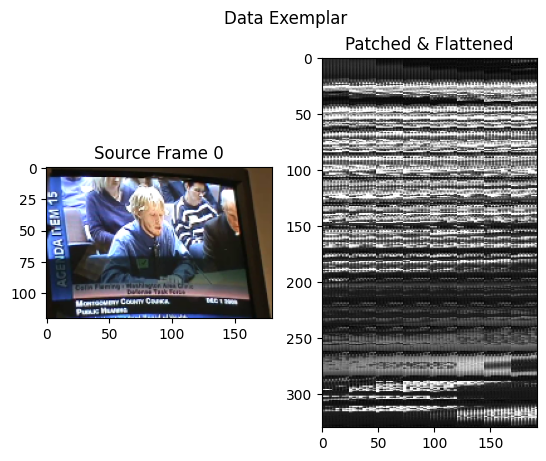

In [23]:
print(f"In flatpatch_list:")
print(f"\tdtype: {type(flatpatch_list[0][1])}")
print(f"\tshape: {flatpatch_list[0][1].shape}")
print(f"\tdtype: {flatpatch_list[0][1].dtype}")

fig, axs = plt.subplots(1,2)
fig.suptitle("Data Exemplar")

axs[1].imshow(flatpatch_list[0][1][0,:,:], cmap='gray')
im_cv = np_video_list[0][1][0,0,:,:,:]
axs[0].imshow( cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB) )

axs[1].set_title('Patched & Flattened')
axs[0].set_title('Source Frame 0')


## 2: Load the Model 

From `EXPERIMENT_FOLDER` we need to instantiate and load the model weights. We can follow the procedure from [execute_experiment.py](https://github.com/amanb2000/Multimodal_Foundation/blob/06bacc67f37c6dfb9de811ca78345fa312d9964d/src/execute_experiment.py#L445)'s code that does this. 

In [25]:
# 1: Getting the args/kwargs for the model
encoder_args = instantiation_params['encoder_args']
encoder_kwargs = instantiation_params['encoder_kwargs']

latent_ev_args = instantiation_params['latent_ev_args']
decoder_args = instantiation_params['decoder_args']

decoder_kwargs = instantiation_params['decoder_kwargs']
latent_ev_kwargs = instantiation_params['latent_ev_kwargs']

perceiver_kwargs = instantiation_params['perceiver_kwargs']

# 2: Loss definition
mse = tf.keras.losses.MeanSquaredError()

# 3: Instantiating component modules
test_encoder = model.PAE_Encoder(*encoder_args, **encoder_kwargs)
test_latent_ev = model.PAE_Latent_Evolver(*latent_ev_args,**latent_ev_kwargs) 
test_decoder = model.PAE_Decoder(*decoder_args, **decoder_kwargs)

# 4: Instantiating the model itself!
perceiver_ae = model.PerceiverAE(mse, test_encoder, test_latent_ev, test_decoder, **perceiver_kwargs)

Initialized latent_init successfully!!


In [29]:
# 5: Loading weights for the model!
latest = tf.train.latest_checkpoint(os.path.join(EXPERIMENT_FOLDER, 'checkpoints'))
print("Latest checkpoint: ", latest)
perceiver_ae.load_weights(latest)
perceiver_ae.reset_latent()
print("Finished loading weights from latest checkpoint!")


Latest checkpoint:  ../training/debug/2022-12-20_15:31:39/checkpoints/cp-0490.ckpt
Finished loading weights from latest checkpoint!


## 3: Create Embeddings using the Model

`NOTE`: We need to make sure our positional codes match the ones the model is expecting. Be sure to generate them, following `execute_experiment.py`'s method of doing that, and append the correct ones to the `FlatPatchSet`-equivalent Tensors. 

Store the embeddings in another parallel list. 

In [ ]:
# Preliminary: We must create positional codes of the correct shape to be concatenated. 
...

In [ ]:
# 1: Exemplar for generating a single embedding. 
...

## 4: Some Cheeky PCA

Also do the inter-cluster distances here :) 

## 5: Linear Probing (Simple sklearn)

Once done, make sure this is actually what they did in ViT-MAE...